In [24]:
from typing import List, Dict
import gensim
import numpy as np

In [37]:
def parse_fasta_dataset(file_path: str = "../data/LTP_09_2021_compressed.fasta.txt", max_seqs:int = False) -> List[Dict[str, str]]:
    dataset = []
    current_idx = 0
    current_meta = {
        "id": "",
        "name": "",
        "tags": [],
        "sequence": ""
    }
    with open(file_path, "r") as f:
        for line in f.readlines():
            if line[0] == ">":
                if current_meta["id"] != "":
                    current_meta["sequence"] = current_meta["sequence"].strip()
                    dataset.append(current_meta)
                line_list = line.replace("\n", "").replace(">", "").split("\t")
                current_meta  = {key: line_list[idx] for idx, key in enumerate(["id", "name", "tags"])}
                current_meta["tags"] = current_meta["tags"].split(";")
                current_meta["sequence"] = ""
                current_idx += 1
                if current_idx > max_seqs and max_seqs>=1:
                    break
            else:
                current_meta["sequence"] += line.replace("\n", " ")
    return dataset

dataset = parse_fasta_dataset(max_seqs=-1)
print(len(dataset))

17959


In [38]:
dataset[0]

{'id': 'AB681979',
 'name': 'Trabulsiella guamensis',
 'tags': ['Bacteria',
  'Proteobacteria',
  'Gammaproteobacteria',
  'Enterobacterales',
  'Enterobacteriaceae',
  'Trabulsiella'],
 'sequence': 'AUUGAACGCU GGCGGCAGGC CUAACACAUG CAAGUCGAGC GGCAGCGGGG GAAAGCUUGC UUUCCCGCCG GCGAGCGGCG GACGGGUGAG UAAUGUCUGG GAAACUGCCU GAUGGAGGGG GAUAACUACU GGAAACGGUA GCUAAUACCG CAUAACGUCU UCGGACCAAA GUGGGGGACC UUCGGGCCUC AUGCCAUCAG AUGUGCCCAG AUGGGAUUAG CUAGUAGGUG GGGUAACGGC UCACCUAGGC GACGAUCCCU AGCUGGUCUG AGAGGAUGAC CAGCCACACU GGAACUGAGA CACGGUCCAG ACUCCUACGG GAGGCAGCAG UGGGGAAUAU UGCACAAUGG GCGCAAGCCU GAUGCAGCCA UGCCGCGUGU AUGAAGAAGG CCUUCGGGUU GUAAAGUACU UUCAGCGGGG AGGAAGGUGU UGUGGUUAAU AACCAGAGCA AUUGACGUUA CCCGCAGAAG AAGCACCGGC UAACUCCGUG CCAGCAGCCG CGGUAAUACG GAGGGUGCAA GCGUUAAUCG GAAUUACUGG GCGUAAAGCG CACGCAGGCG GUCUGUCAAG UCGGAUGUGA AAUCCCCGGG CUCAACCUGG GAACUGCAUC CGAAACUGGC AGGCUUGAGU CUUGUAGAGG GGGGUAGAAU UCCAGGUGUA GCGGUGAAAU GCGUAGAGAU CUGGAGGAAU ACCGGUGGCG AAGGCGGCCC CCUGGACAAA GACUGACG

In [76]:
BASES = {"A": "000", "C": "001", "G": "010", "T": "011", "_": "100"}

def is_valid_padding(key_string: str) -> bool:
    if "_" not in key_string[:-2] and key_string[-1] == "_":
        return True
    elif "_" not in key_string[:-3] and key_string[-2:] == "__":
        return True
    elif "_" not in key_string[:-4] and key_string[-3:] == "___":
        return True
    return False

BASE_MAP = {}

for key1, val1 in BASES.items():
    for key2, val2 in BASES.items():
        for key3, val3 in BASES.items():
            for key4, val4 in BASES.items():
                key_string = key1 + key2 + key3 + key4
                if "_" not in key_string:
                    print(
                        key1 + key2 + key3 + key4,
                        "->",
                        val1 + val2 + val3 + val4,
                        "(",
                        int(val1 + val2 + val3 + val4, base=2),
                        ")",
                    )
                    BASE_MAP[key1 + key2 + key3 + key4] = int(
                        val1 + val2 + val3 + val4, base=2
                    )
                else:
                    if is_valid_padding(key_string):
                        print(
                            key1 + key2 + key3 + key4,
                            "->",
                            val1 + val2 + val3 + val4,
                            "(",
                            int(val1 + val2 + val3 + val4, base=2),
                            ")",
                        )
                        BASE_MAP[key1 + key2 + key3 + key4] = int(
                            val1 + val2 + val3 + val4, base=2
                        )

for key, val in SPECIAL.items():
    BASE_MAP[key] = val


print(BASE_MAP)
print(len(BASE_MAP))

AAAA -> 000000000000 ( 0 )
AAAC -> 000000000001 ( 1 )
AAAG -> 000000000010 ( 2 )
AAAT -> 000000000011 ( 3 )
AAA_ -> 000000000100 ( 4 )
AACA -> 000000001000 ( 8 )
AACC -> 000000001001 ( 9 )
AACG -> 000000001010 ( 10 )
AACT -> 000000001011 ( 11 )
AAC_ -> 000000001100 ( 12 )
AAGA -> 000000010000 ( 16 )
AAGC -> 000000010001 ( 17 )
AAGG -> 000000010010 ( 18 )
AAGT -> 000000010011 ( 19 )
AAG_ -> 000000010100 ( 20 )
AATA -> 000000011000 ( 24 )
AATC -> 000000011001 ( 25 )
AATG -> 000000011010 ( 26 )
AATT -> 000000011011 ( 27 )
AAT_ -> 000000011100 ( 28 )
AA__ -> 000000100100 ( 36 )
ACAA -> 000001000000 ( 64 )
ACAC -> 000001000001 ( 65 )
ACAG -> 000001000010 ( 66 )
ACAT -> 000001000011 ( 67 )
ACA_ -> 000001000100 ( 68 )
ACCA -> 000001001000 ( 72 )
ACCC -> 000001001001 ( 73 )
ACCG -> 000001001010 ( 74 )
ACCT -> 000001001011 ( 75 )
ACC_ -> 000001001100 ( 76 )
ACGA -> 000001010000 ( 80 )
ACGC -> 000001010001 ( 81 )
ACGG -> 000001010010 ( 82 )
ACGT -> 000001010011 ( 83 )
ACG_ -> 000001010100 ( 84 )

In [77]:
def chunk_seq(seq: str, chunk_len: int = 4):
    ret_list = []
    chunk = ""
    for idx, char in enumerate(seq):
        chunk += char
        if len(chunk) % chunk_len ==0:
            ret_list.append(chunk)
            chunk=""
    if len(chunk) > 0:
        ret_list.append("{}{}".format(chunk, "_"*(4-len(chunk))))
    return ret_list

clean_seq = dataset[0]["sequence"].replace(" ", "")
chunks = chunk_seq(clean_seq)
print(chunks)

['AUUG', 'AACG', 'CUGG', 'CGGC', 'AGGC', 'CUAA', 'CACA', 'UGCA', 'AGUC', 'GAGC', 'GGCA', 'GCGG', 'GGGA', 'AAGC', 'UUGC', 'UUUC', 'CCGC', 'CGGC', 'GAGC', 'GGCG', 'GACG', 'GGUG', 'AGUA', 'AUGU', 'CUGG', 'GAAA', 'CUGC', 'CUGA', 'UGGA', 'GGGG', 'GAUA', 'ACUA', 'CUGG', 'AAAC', 'GGUA', 'GCUA', 'AUAC', 'CGCA', 'UAAC', 'GUCU', 'UCGG', 'ACCA', 'AAGU', 'GGGG', 'GACC', 'UUCG', 'GGCC', 'UCAU', 'GCCA', 'UCAG', 'AUGU', 'GCCC', 'AGAU', 'GGGA', 'UUAG', 'CUAG', 'UAGG', 'UGGG', 'GUAA', 'CGGC', 'UCAC', 'CUAG', 'GCGA', 'CGAU', 'CCCU', 'AGCU', 'GGUC', 'UGAG', 'AGGA', 'UGAC', 'CAGC', 'CACA', 'CUGG', 'AACU', 'GAGA', 'CACG', 'GUCC', 'AGAC', 'UCCU', 'ACGG', 'GAGG', 'CAGC', 'AGUG', 'GGGA', 'AUAU', 'UGCA', 'CAAU', 'GGGC', 'GCAA', 'GCCU', 'GAUG', 'CAGC', 'CAUG', 'CCGC', 'GUGU', 'AUGA', 'AGAA', 'GGCC', 'UUCG', 'GGUU', 'GUAA', 'AGUA', 'CUUU', 'CAGC', 'GGGG', 'AGGA', 'AGGU', 'GUUG', 'UGGU', 'UAAU', 'AACC', 'AGAG', 'CAAU', 'UGAC', 'GUUA', 'CCCG', 'CAGA', 'AGAA', 'GCAC', 'CGGC', 'UAAC', 'UCCG', 'UGCC', 'AGCA', 'GCCG',

In [237]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(x["sequence"], [x["tags"][3]]) for x in dataset]

In [247]:
model = gensim.models.Doc2Vec(
    documents=documents, 
    workers=12, 
    vector_size=32,
    negative=10,
)

In [248]:
[(x, y) for x, y in model.docvecs.doctags.items()]

[('Enterobacterales', Doctag(offset=0, word_count=675604, doc_count=422)),
 ('Micrococcales', Doctag(offset=1, word_count=1467720, doc_count=912)),
 ('Flavobacteriales', Doctag(offset=2, word_count=1733863, doc_count=1087)),
 ('Pasteurellales', Doctag(offset=3, word_count=172901, doc_count=111)),
 ('Orbales', Doctag(offset=4, word_count=16291, doc_count=10)),
 ('Gammaproteobacteria_incertae_sedis',
  Doctag(offset=5, word_count=63358, doc_count=40)),
 ('Aeromonadales', Doctag(offset=6, word_count=108566, doc_count=68)),
 ('Vibrionales', Doctag(offset=7, word_count=327032, doc_count=204)),
 ('Alteromonadales', Doctag(offset=8, word_count=433501, doc_count=268)),
 ('Moraxellales', Doctag(offset=9, word_count=957941, doc_count=592)),
 ('Chromatiales', Doctag(offset=10, word_count=258577, doc_count=161)),
 ('Kangiellales', Doctag(offset=11, word_count=537543, doc_count=332)),
 ('Thermoleophilales', Doctag(offset=12, word_count=3207, doc_count=2)),
 ('Cellvibrionales', Doctag(offset=13, wor

In [249]:
model.docvecs.doctags.keys()

dict_keys(['Enterobacterales', 'Micrococcales', 'Flavobacteriales', 'Pasteurellales', 'Orbales', 'Gammaproteobacteria_incertae_sedis', 'Aeromonadales', 'Vibrionales', 'Alteromonadales', 'Moraxellales', 'Chromatiales', 'Kangiellales', 'Thermoleophilales', 'Cellvibrionales', 'Legionellales', 'Thiotrichales', 'Holosporales', 'Arenicellales', 'Methylococcales', 'Neisseriales', 'Nevskiales', 'Acidiferrobacterales', 'Cardiobacteriales', 'Burkholderiales', 'Streptosporangiales', 'Nitrosomonadales', 'Betaproteobacteria_incertae_sedis', 'Rhodocyclales', 'Hydrogenophilales', 'Hydrogenophylalia_incertae_sedis', 'Lysobacterales', 'Immundisolibacterales', 'Acidithiobacillales', 'Mariprofundales', 'Rhodobacterales', 'Maricaulales', 'Minwuiales', 'Caulobacterales', 'Streptomycetales', 'Hyphomonadales', '"Parvularculales"', '""Parvularculales""', 'Hyphomicrobiales', 'Sphingomonadales', 'Sphingobacteriales', 'Micropepsales', 'Kordiimonadales', 'Iodidimonadales', 'Emcibacterales', 'Rhodospirillales', 'R

In [250]:
seq_ids = {key: model.docvecs[key] for key in model.docvecs.doctags.keys()}

In [251]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns

def plot_nodes(seq_ids: Dict[str, np.array]):
    X = [x for x in seq_ids.values()]
    
    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    plt.figure(figsize=(30,30))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1], cmap=sns.color_palette("Spectral", as_cmap=True))
    for i, word in enumerate([x for x in seq_ids.keys()]):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    
    plt.show()

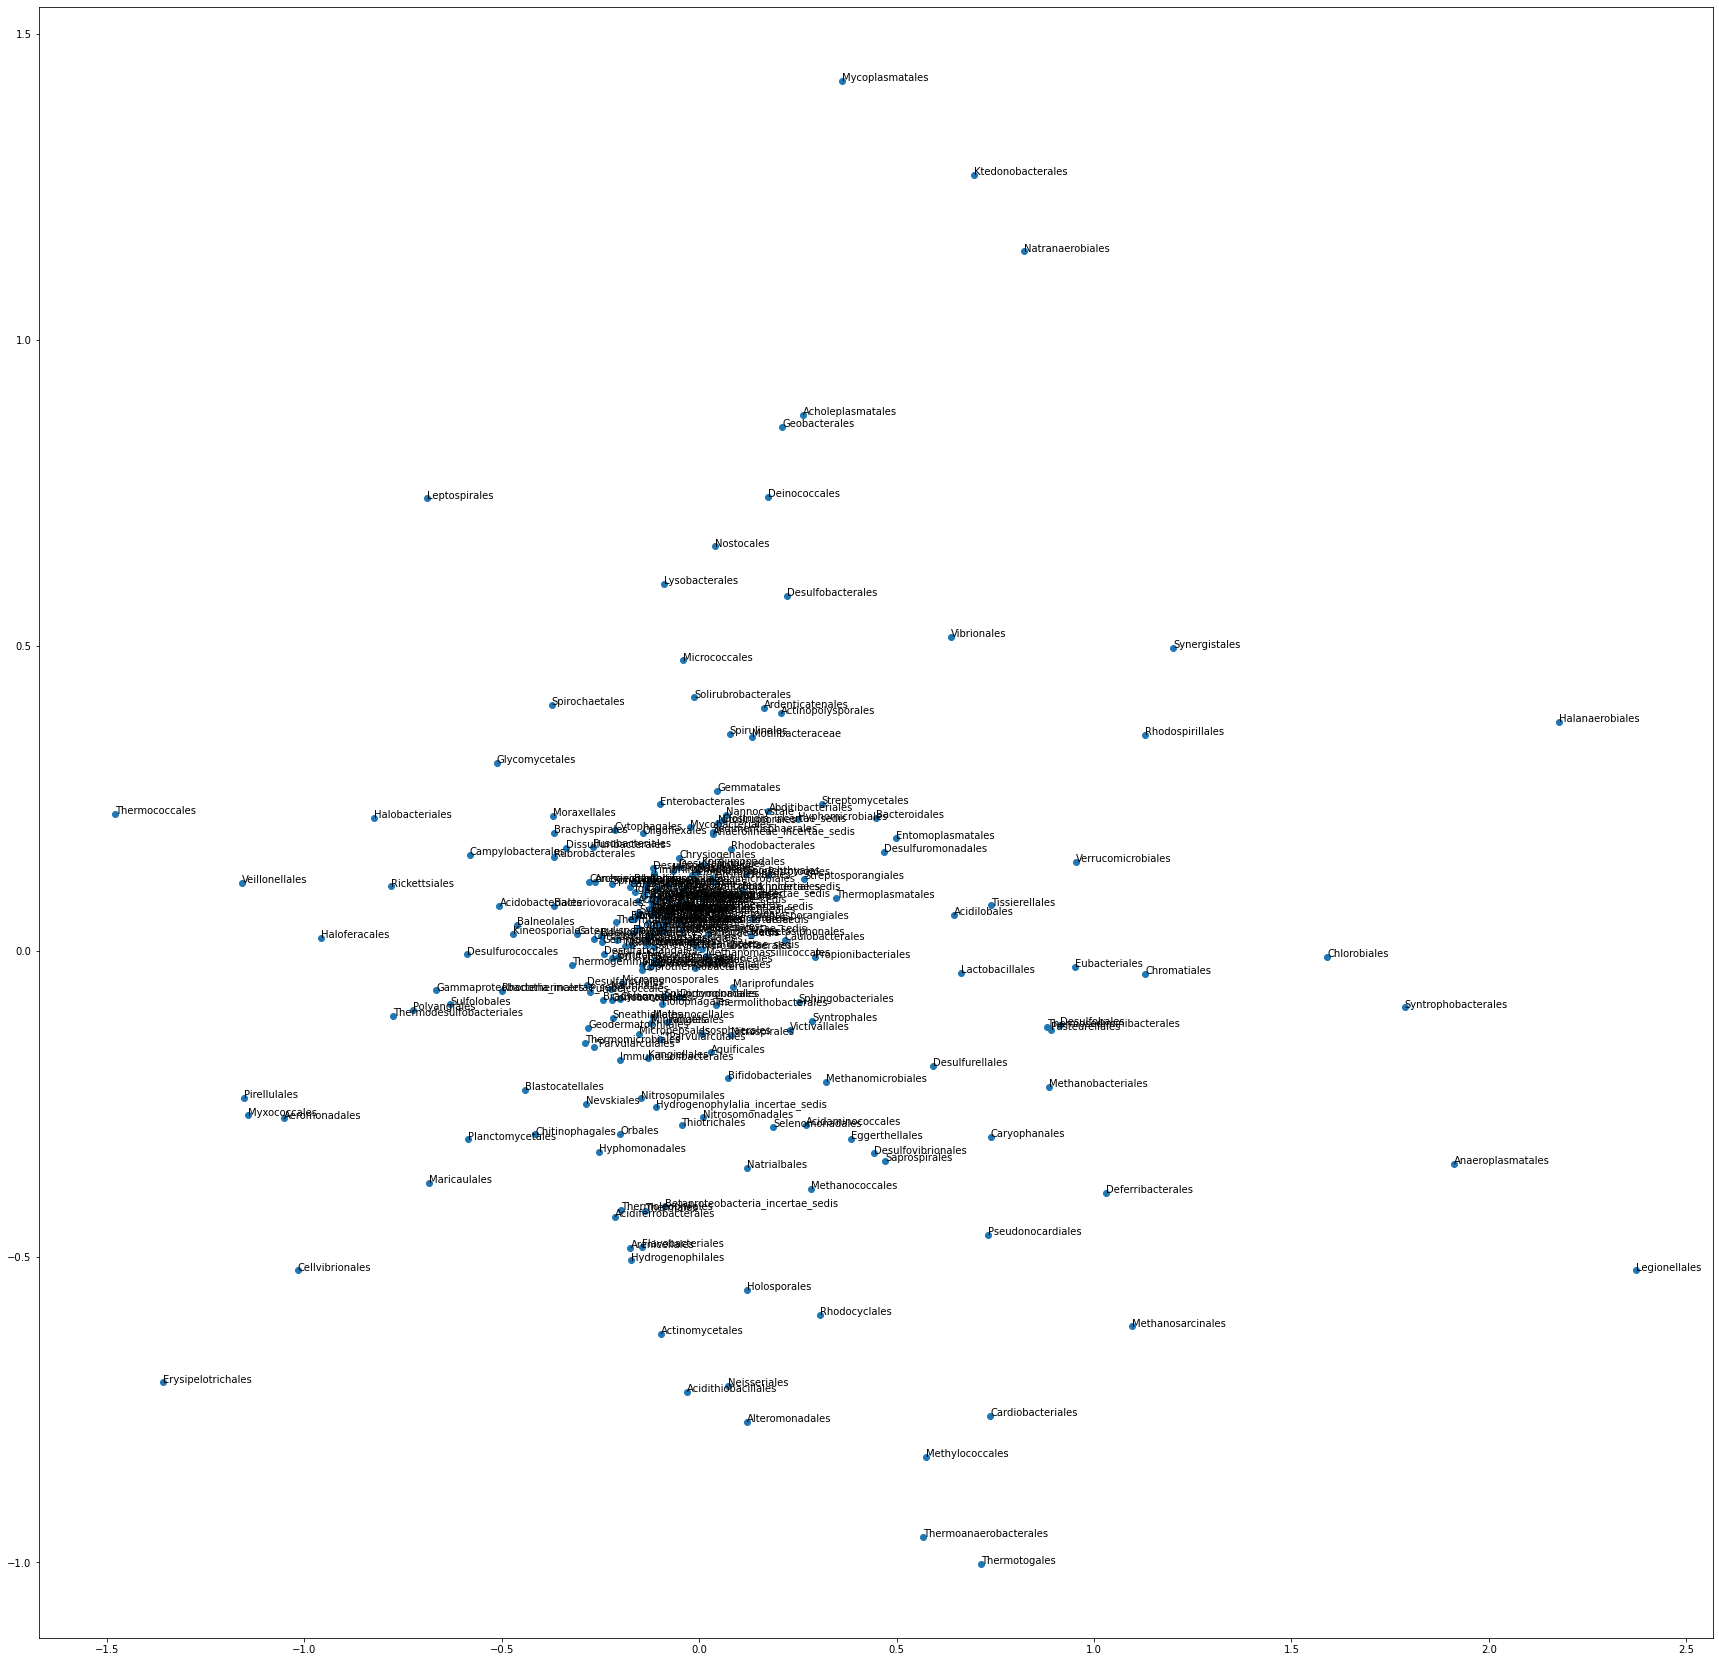

In [252]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return dict(islice(iterable, n))

random_sample = take(10000, seq_ids.items())

plot_nodes(random_sample)